In [27]:
# make synthetic dataset

In [58]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [46]:
n_samples = 200

In [47]:
# how the training/dev/test data is distributed
def y_gen(x):
    return np.maximum(x, 0)

# how the production data is distributed
def y_gen_prod(x):
    return 0.5 * np.maximum(x, 0)


def y_obs(x, f):
    y = f(x)
    return y + np.random.normal(0, 0.3, size = len(y))

In [48]:
x = np.random.uniform(-5, 5, size = n_samples)
y = y_obs(x, y_gen)

x_underlying = np.linspace(-5, 5, num = n_samples)
y_underlying = y_gen(x_underlying)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

In [50]:
x_prod = np.random.uniform(-5, 5, size = n_samples)
y_prod = y_obs(x_prod, f = y_gen_prod)

x_underlying_prod = np.linspace(-5, 5, num = n_samples)
y_underlying_prod = y_gen_prod(x_underlying)

In [94]:
model = keras.Sequential(
    [
        keras.Input(shape = (1,)),
        keras.layers.Dense(2, activation="relu", name="layer1"),
        keras.layers.Dense(1, name="layer2")
    ]
)

In [95]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

In [96]:
hist = model.fit(
    x = x_train,
    y = y_train,
    validation_split = 0.25,
    epochs = 100,
    verbose = 0
)

In [97]:
hist_df = pd.DataFrame.from_dict(hist.history)

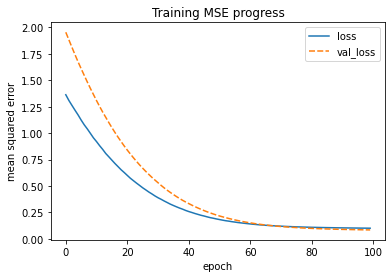

In [98]:
plt.title('Training MSE progress')

sns.lineplot(data = hist_df)
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.show()

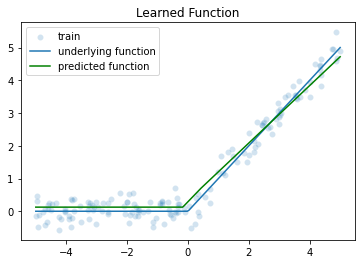

In [100]:
plt.title('Learned Function')

# training data 
sns.scatterplot(x = x_train, y = y_train, label = 'train', alpha = 0.2)
sns.lineplot(x = x_underlying, y = y_underlying, label = 'underlying function')

# pred data 
sns.lineplot(x = x_underlying, y = y_pred, label = 'predicted function', color = 'green')

plt.show()

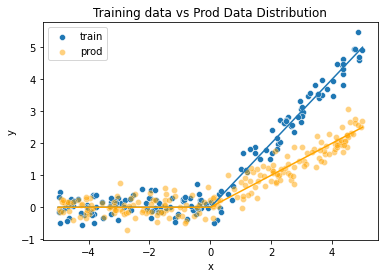

In [93]:
plt.title('Training data vs Prod Data Distribution')

# training data 
sns.scatterplot(x = x_train, y = y_train, label = 'train')
#sns.scatterplot(x = x_test, y = y_test, label = 'test', color = 'red')
sns.lineplot(x = x_underlying, y = y_underlying)

# prod data
sns.scatterplot(x = x_prod, y = y_prod, label = 'prod', color = 'orange', alpha = 0.5)
sns.lineplot(x = x_underlying_prod, y = y_underlying_prod, color = 'orange')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

In [99]:
y_pred = model.predict(x_underlying)[:, 0]

In [101]:
model.evaluate(x = x_test, y = y_test) # test MSE

2/2 [==============================] - 0s 3ms/step - loss: 0.1118


0.1118098646402359

In [102]:
model.evaluate(x = x_prod, y = y_prod) # prod MSE

7/7 [==============================] - 0s 1ms/step - loss: 1.2242


1.224155306816101

This prod data was never of the same underlying distribution as the train/test data. We'd like to simulate a time-series performance of this model if it were fed this data one-at-a-time.

In [116]:
y_pred_prod = model.predict(x_prod).flatten()
y_error = y_pred_prod - y_prod

time = np.arange(0, len(y_prod))

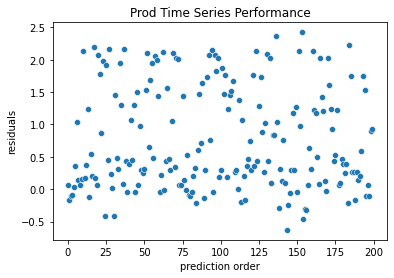

In [119]:
plt.title('Prod Time Series Performance')

sns.scatterplot(x = time, y = y_error)
plt.xlabel('prediction order')
plt.ylabel('residuals')

plt.show()

In [151]:
prod_perf_df = pd.DataFrame({
    'time': time,
    'residual': y_error,
    'sq_error': y_error ** 2
})

window_size = 40

prod_perf_df['rolling_squared_error_median'] = prod_perf_df['sq_error'].rolling(window_size).quantile(.5)
prod_perf_df['rolling_squared_error_lqrt'] = prod_perf_df['sq_error'].rolling(window_size).quantile(.25)
prod_perf_df['rolling_squared_error_uqrt'] = prod_perf_df['sq_error'].rolling(window_size).quantile(.75)

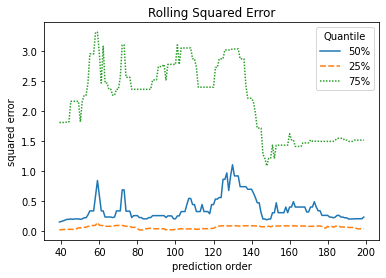

In [152]:
plt.title('Rolling Squared Error')

sns.lineplot(
    data = prod_perf_df[
        ['rolling_squared_error_median', 'rolling_squared_error_lqrt', 'rolling_squared_error_uqrt']
    ]
)

plt.xlabel('prediction order')
plt.ylabel('squared error')
plt.legend(title='Quantile', labels=['50%', '25%', '75%'])

plt.show()

We are evaluating the quality of the learned function on prod data that is "thresholded" different than the train/test data. Next, we'd like to evaluate it on prod data that shifts over time to get a time-series performance.